# TODO
1. Ποσοστο πληροτητας ανα μηνα/χρονο κλπ με βαση την αποσταση απο το τουριστικο κεντρο
2. Ποσοστο ανα περιοχη που οι ιδιοκτητες ειναι μεγαλο-ιδιοκτητες (πχ ενας μεγαλοιδιοκτητης θα αγορασει συνταγμα οχι κυψελη) και θα εξηγω γιατι αν μια περιοχη ειναι καρα κεντρο ενδεχομενως να μην εχει πολλες κρατησεις (ισως ειναι γκετο)
3. Ποσοστο reviews ανα περιοχη, για να δουμε ποιες περιοχες εχουν τα καλυτερα διαμερισματα με βαση το ποσοι πελατες μενουν ευχαειστημενοι (αφηνουν review)

# Exploring AirBnB in Europe

A lot has been said and written about the effect of AirBnB around the world. In this assignment, you will use the data collected by [Inside AirBnB](http://insideairbnb.com).

Once you do that, spend some time familiarizing yourself with the data and then go ahead and do the following tasks. In the following questions, you will use data for the following cities:

* Amsterdam

* Athens

* Barcelona

* Berlin

* Copenhagen

* Dublin

* Lisbon

* London

* Madrid

* Paris

* Rome

* Venice

* Vienna

You will use the data for the latest 12 months period for which data is available.

In [3]:
import os
import pandas as pd

import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import seaborn as sns

In [4]:
cities = ["amsterdam", "athens", "barcelona", "berlin", "copenhagen", "dublin", "lisbon", "london", "madrid", "paris", "rome", "venice", "vienna"]
# cities = ["vienna", "athens"]

files = ["calendar.csv.gz", "listings.csv", "neighbourhoods.csv", "reviews.csv"]

# Path to the main data folder
data_path = "./data"

# Dictionary to hold data
data = {}

for city in cities:
    data[city] = {}
    city_folder = os.path.join(data_path, city)
    
    for file in files:
        file_path = os.path.join(city_folder, file)
        
        # Load the file into a DataFrame based on file extension and save to dictionary
        try:
            if file.endswith(".csv.gz"):
                data[city]["calendar"] = pd.read_csv(file_path, compression="gzip")
            else:
                key_name = f"{file.split('.')[0]}"  # Strip extension for consistent naming
                data[city][key_name] = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found.")
            
print("Data successfully loaded into the data dictionary.")


/var/folders/27/w24km3fs2vl7bm7hlvrwm2l40000gn/T/ipykernel_23693/3555396762.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data[city]["calendar"] = pd.read_csv(file_path, compression="gzip")
/var/folders/27/w24km3fs2vl7bm7hlvrwm2l40000gn/T/ipykernel_23693/3555396762.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data[city]["calendar"] = pd.read_csv(file_path, compression="gzip")
/var/folders/27/w24km3fs2vl7bm7hlvrwm2l40000gn/T/ipykernel_23693/3555396762.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data[city]["calendar"] = pd.read_csv(file_path, compression="gzip")
/var/folders/27/w24km3fs2vl7bm7hlvrwm2l40000gn/T/ipykernel_23693/3555396762.py:22: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data[city]["calendar"] = pd.read_csv(file_path, compress

Data successfully loaded into the data dictionary.


In [5]:
data['athens']['listings'].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,10595,"3 bedrooms, 2 bathrooms, 2nd floor with elevator",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98863,23.76527,Entire home/apt,108.0,1,52,2024-06-03,0.33,7,140,11,00002433180
1,10990,Athens Quality Apartments - Deluxe Apartment,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,136.0,1,78,2024-04-30,0.54,7,158,13,00002433169
2,10993,Athens Quality Apartments - Studio,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98888,23.76473,Entire home/apt,67.0,1,96,2024-06-20,0.67,7,172,5,00002433010
3,10995,"AQA-No2 1-bedroom, smart tv, fiber connection,",37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98903,23.76448,Entire home/apt,78.0,1,32,2024-03-09,0.19,7,142,2,00002433153
4,27262,Athens Quality Apartments - Ground floor apart...,37177,Emmanouil,NaN,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire home/apt,58.0,1,25,2024-01-13,0.17,7,172,4,00002433111


## Cleaning the Data
We need to clean the data in order for our calculations later on to work as expected, and also have as accurate results as possible.

We can see here that for the 'listings' csv for each country:
1. **neigbourhood_group**, the neigbourhood_group column is most of the times null. In these cities, we will replace each null value with a default value and handle it accordingly later on.
2. **price**, sometimes we have a null value in the price column. In these cities, we will replace each null value with a default value and handle it accordingly later on.
3. **reviews**, some listings also probably do not have any reviews. In that case we will just replace the null values with 0.
4. **license**, in some cities, we do not have most or sometimes even all of the licenses for the listings. This is also a problem, but we will have to **ignore** it, and give each null license value a default value to handle it accordingly later.
5. **host_name**, sometimes we get null values in the host_name. Because of the fact that we will surely need this information later on, and the null entries are too little, we will replace the values with an empty string.

<Figure size 1400x800 with 0 Axes>

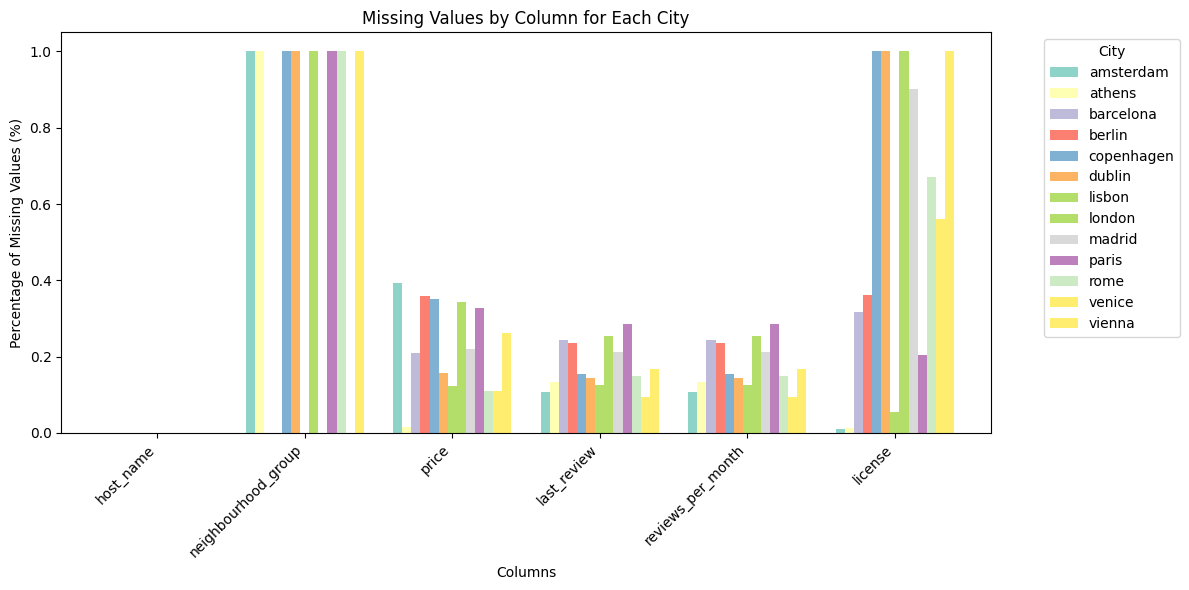

In [6]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['listings'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
def clean_listings(data):
    data['neighbourhood_group'].fillna("", inplace=True)
    data['price'].fillna(0, inplace=True)
    data['number_of_reviews'].fillna(0, inplace=True)
    data['last_review'].fillna('0000-00-00', inplace=True)
    data['reviews_per_month'].fillna(0, inplace=True)
    data['license'].fillna("", inplace=True)
    data['host_name'].fillna("", inplace=True)
    
    return data

We can see after the clean up of the listings datasets that there are no null values left. 

<Figure size 1400x800 with 0 Axes>

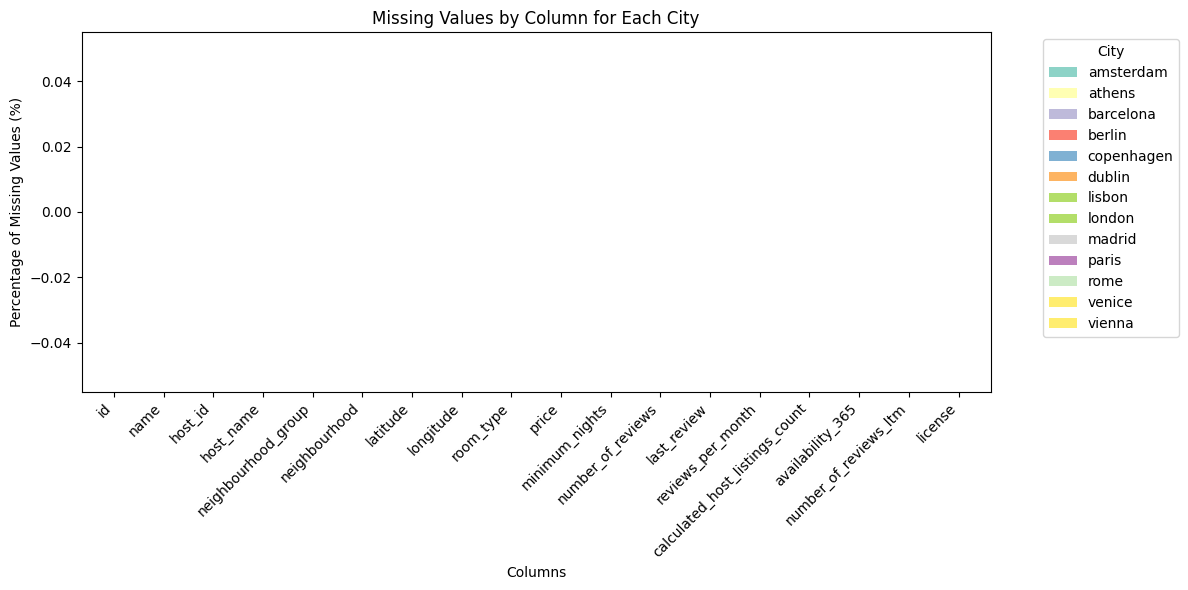

In [8]:
missing_data = {}

for city, datasets in data.items():
    datasets['listings'] = clean_listings(datasets['listings'])
    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['listings'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
data['athens']['reviews']

,listing_id,date
0,1154316,2013-06-28
1,3428808,2014-08-23
2,3428808,2014-08-28
3,3428808,2014-09-01
4,3428808,2014-09-08
...,...,...
688089,1176519625091585294,2024-06-14
688090,1176577066611811151,2024-06-15
688091,1176583371616472880,2024-06-24
688092,1176583684597030829,2024-06-24


The reviews dataset does not contain any null values. We will not encounter any problem with this dataset later on so we keep it as is.

<Figure size 1400x800 with 0 Axes>

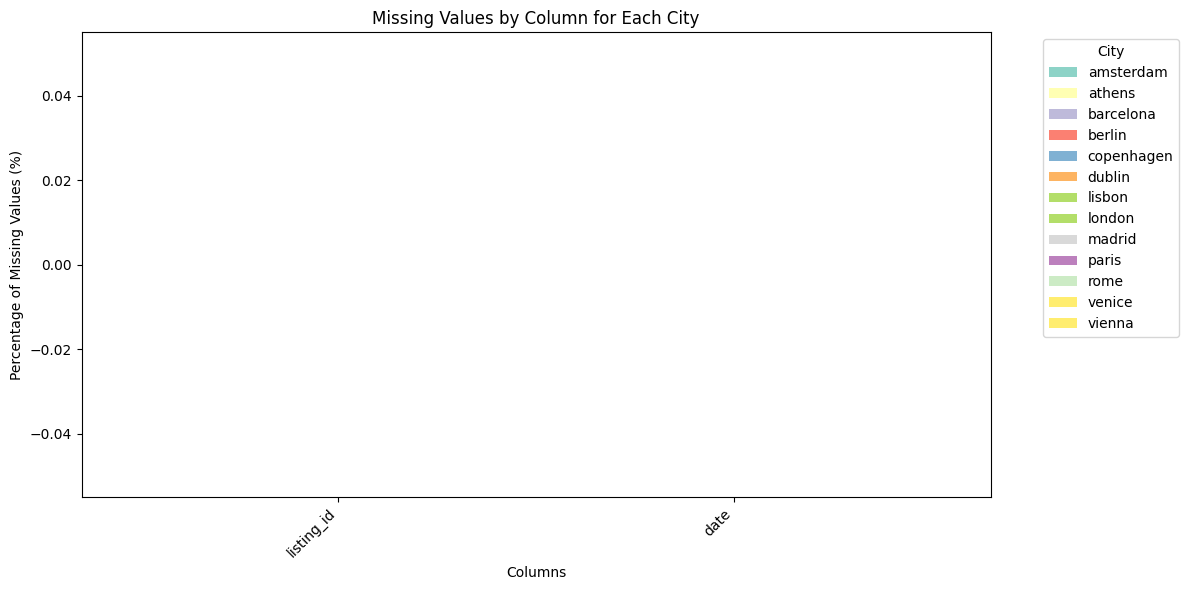

In [10]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['reviews'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [11]:
data['amsterdam']['calendar']

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2024-09-06,f,$69.00,NaN,3.0,1125.0
1,2818,2024-09-07,f,$69.00,NaN,3.0,1125.0
2,2818,2024-09-08,f,$69.00,NaN,3.0,1125.0
3,2818,2024-09-09,f,$69.00,NaN,3.0,1125.0
4,2818,2024-09-10,t,$69.00,NaN,3.0,1125.0
...,...,...,...,...,...,...,...
3525169,1238449706748135184,2025-09-01,t,$280.00,NaN,1.0,365.0
3525170,1238449706748135184,2025-09-02,t,$280.00,NaN,1.0,365.0
3525171,1238449706748135184,2025-09-03,t,$280.00,NaN,1.0,365.0
3525172,1238449706748135184,2025-09-04,t,$280.00,NaN,1.0,365.0


In the calendar dataset we get:
1. **adjusted_price**, the adjusted price most of the times is null. We can replace each null entry with 0 for our calculations.
2. **maximum_nights and minimum_nights**, the maximum and minumum nights which somethimes contains null values. We can also replace each of these empty entries with 0.

<Figure size 1400x800 with 0 Axes>

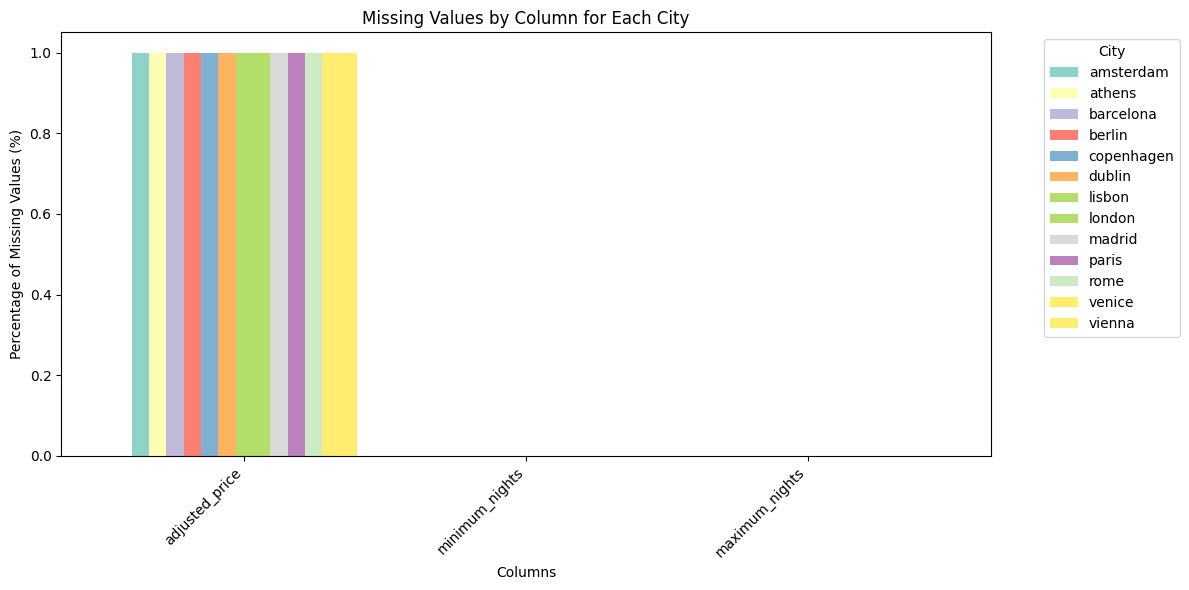

In [12]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['calendar'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [13]:
def clean_calendar(data):
    data['adjusted_price'].fillna(0, inplace=True)
    data['minimum_nights'].fillna(0, inplace=True)
    data['maximum_nights'].fillna(0, inplace=True)
    
    return data

We can see after the clean up of the calendar datasets that there are no null values left. 

<Figure size 1400x800 with 0 Axes>

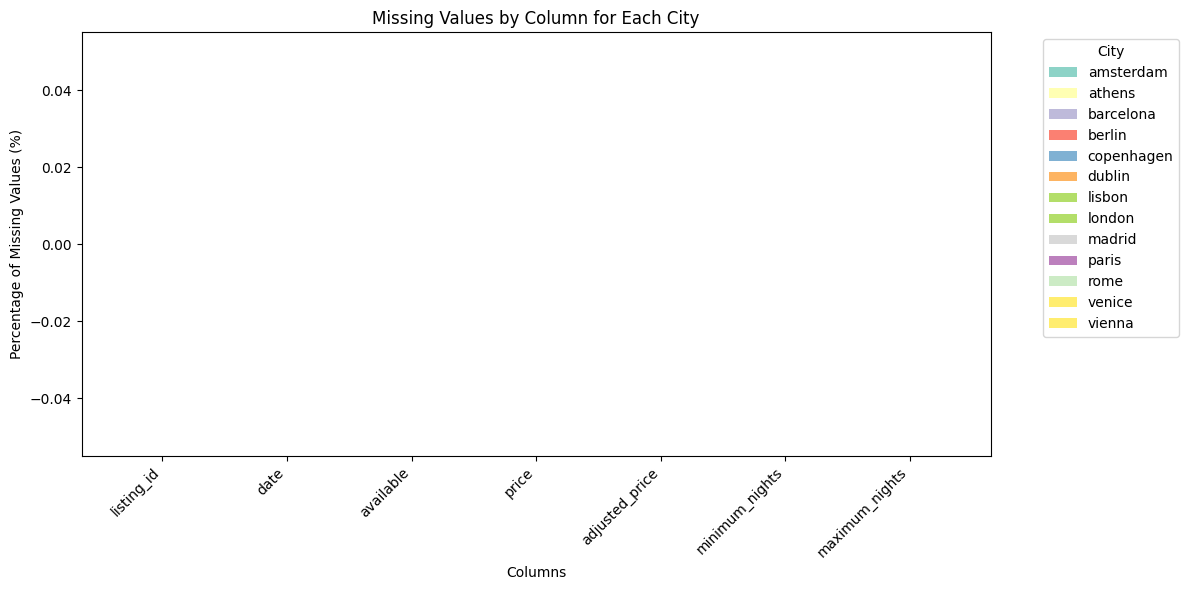

In [14]:
missing_data = {}

for city, datasets in data.items():    
    datasets['calendar'] = clean_calendar(datasets['calendar'])

    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['calendar'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [15]:
data['venice']['neighbourhoods']

,neighbourhood_group,neighbourhood
0,Isole,Alberoni
1,Isole,Burano
2,Isole,Cannaregio
3,Isole,Castello
4,Isole,Dorsoduro
...,...,...
109,Terraferma,Villabona
110,Terraferma,Villaggio San Marco
111,Terraferma,Villaggio Sartori
112,Terraferma,Zelarino


In the neighbourhoods dataset we can see that most of the times the **neighbourhood_group** is empty. We can replace each empty entry with an empty string for our convenience.
Most important than that, though, is the fact that we have null values in the **neigbourhood** column. This is a big problem for us because it involves one of our most important informations.
For that reason, we will completely delete each row that contains an empty neigbourhood value.

<Figure size 1400x800 with 0 Axes>

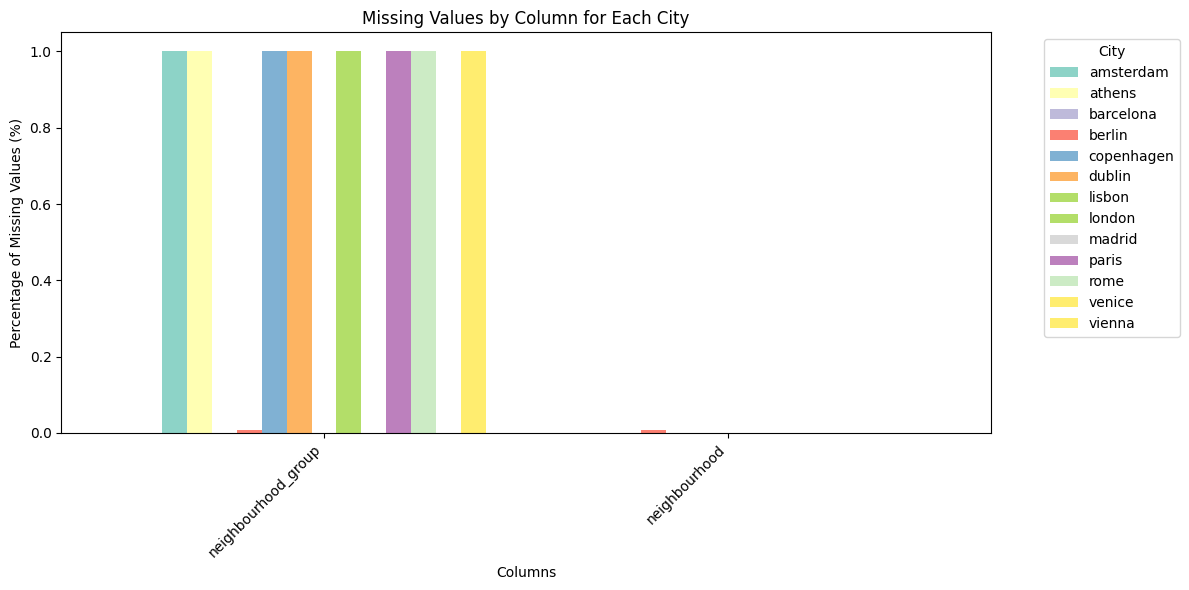

In [16]:
missing_data = {}

for city, datasets in data.items():    
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['neighbourhoods'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Filter out columns with no missing values in any city
missing_df = missing_df.loc[missing_df.sum(axis=1) > 0]

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [17]:
def clean_neighbourhoods(data):
    data['neighbourhood_group'].fillna("", inplace=True)
    data.dropna(subset=['neighbourhood'], inplace=True)
        
    return data

We can see after the clean up of the neighbourhood datasets that there are no null values left. 

<Figure size 1400x800 with 0 Axes>

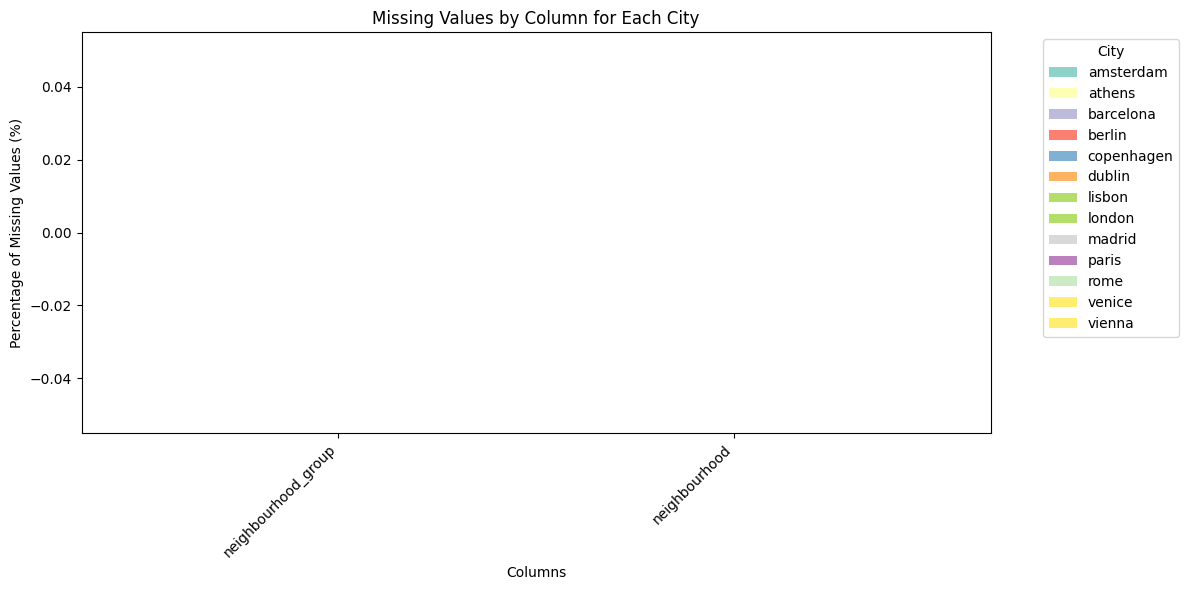

In [18]:
missing_data = {}

for city, datasets in data.items(): 
    datasets['neighbourhoods'] = clean_neighbourhoods(datasets['neighbourhoods'])
   
    # Calculate percentage of missing values for each column
    missing_data[city] = datasets['neighbourhoods'].isnull().mean()

# Convert to a DataFrame for easier plotting
missing_df = pd.DataFrame(missing_data)

# Plotting
plt.figure(figsize=(14, 8))
missing_df.plot(kind='bar', width=0.8, figsize=(12, 6), colormap="Set3")
plt.ylabel("Percentage of Missing Values (%)")
plt.xlabel("Columns")
plt.title("Missing Values by Column for Each City")
plt.xticks(rotation=45, ha='right')
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## AirBnB Listings

Find the number of AirBnB listings per city. Show the information in tabular format, and also make a plot.

In [19]:
# declare dictionary which will hold our information
no_listings_per_city = {}

In [20]:
for city, datasets in data.items():
    no_listings_per_city[city] = len(datasets['listings'])

In [21]:
listings_per_city_df = pd.DataFrame(list(no_listings_per_city.items()), columns=['City', 'Listings'])
listings_per_city_df = listings_per_city_df.sort_values(by='Listings', ascending=False)

print("Number of AirBnb Listings per City:")
listings_per_city_df

Number of AirBnb Listings per City:


,City,Listings
7,london,96182
9,paris,95461
10,rome,34061
8,madrid,26980
6,lisbon,24204
4,copenhagen,20909
2,barcelona,19482
12,vienna,14396
3,berlin,13759
1,athens,13274


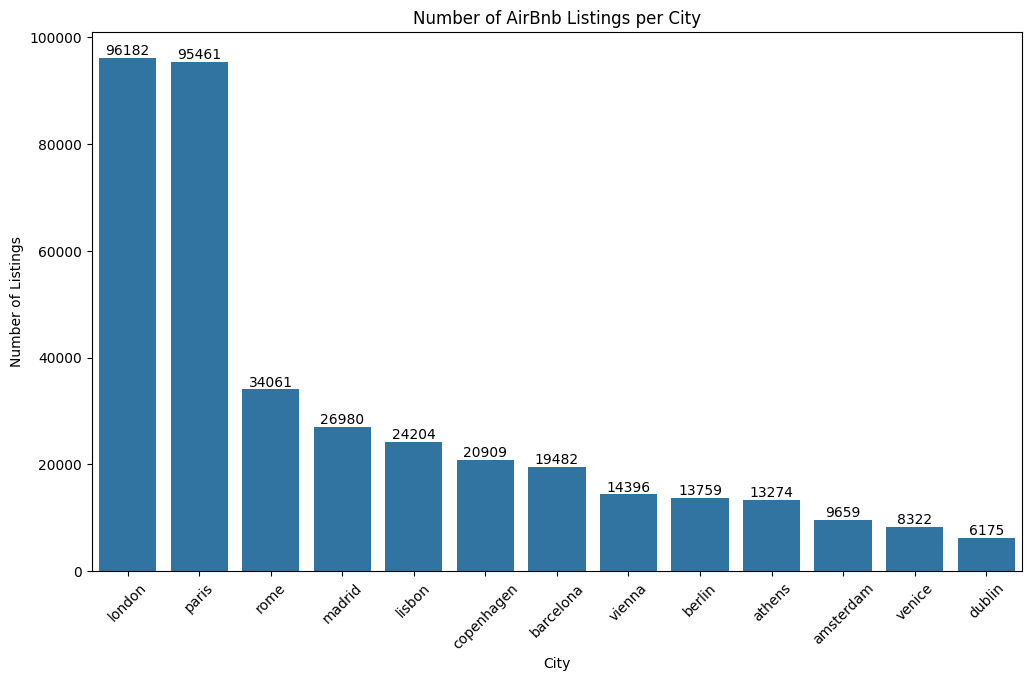

In [22]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Number of Listings')
plt.title('Number of AirBnb Listings per City')
plt.xticks(rotation=45)
ax = sns.barplot(listings_per_city_df, x="City", y="Listings", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### Observations
This list closely resembles the official ["Most visited cities in Europe"](https://thesavvybackpacker.com/most-visited-cities-in-europe/). When a city attracts a large number of tourists, its economy is heavily influenced by the demand for accommodations. This helps explain why the most popular tourist destinations often have the highest number of AirBnb listings. 

One really interesting observation, is that even though Amsterdam has a lot more tourists visiting each year, Madrid holds more than twice the amount of AirBnb listings. This can be related to:
1. **Regulatory Differences**: Amsterdam has implemented strict regulations on short-term rentals, including AirBnb. These rules limit the number of days properties can be rented out each year, require registration, and impose fines for non-compliance. Madrid, on the other hand, has generally had more lenient regulations, allowing more listings to flourish.

2. **Availability of Residential Space**: Madrid is a larger city in terms of land area, offering more residential space where AirBnb listings can be hosted. This greater space might contribute to a higher number of listings compared to the more compact Amsterdam.

3. **Local Demand and Usage**: In addition to international tourists, Madrid's AirBnb market may also cater to domestic tourists or long-term stays, as it’s a popular destination within Spain. This broader usage could contribute to a higher overall number of listings.

4. **Tourism Preferences**: Amsterdam has a higher proportion of traditional hotel accommodations compared to Madrid. Many tourists may prefer the established hotel sector in Amsterdam, while in Madrid, visitors may be more inclined to book alternative accommodations, like AirBnb, especially if they're seeking a local experience or longer stays.

## AirBnB Densities

Apart from the number of distinct listings, we are interested in the density, that is, the number of AirBnB listings per 1,000 inhabitants, again for the latest 12 months period for which data is available. You must determine the number of inhabitants per city in the most appropriate way. Show the information in tabular format, and also make a plot.

### Population of Selected Cities (2024)

The table below presents the population of various cities as of 2024, based on data sourced from [World Population Review](https://worldpopulationreview.com/) and additional resources.

| City          | Population | Source |
|---------------|------------|--------|
| Athens        | 643,452    | [Wikipedia - Δήμος Αθηναίων](https://el.wikipedia.org/wiki/Κατάλογος_δήμων_της_Ελλάδας) |
| Amsterdam     | 1,181,820  | [World Population Review](https://worldpopulationreview.com/cities/netherlands/amsterdam) |
| Barcelona     | 5,711,920  | [World Population Review](https://worldpopulationreview.com/cities/spain/barcelona) |
| Berlin        | 3,576,870  | [World Population Review](https://worldpopulationreview.com/cities/germany/berlin) |
| Copenhagen    | 1,391,200  | [World Population Review](https://worldpopulationreview.com/) |
| Dublin        | 1,284,550  | [World Population Review](https://worldpopulationreview.com/) |
| Lisbon        | 3,014,610  | [World Population Review](https://worldpopulationreview.com/) |
| London        | 9,748,030  | [World Population Review](https://worldpopulationreview.com/) |
| Madrid        | 3,286,080  | [World Population Review](https://worldpopulationreview.com/cities/spain/madrid) |
| Paris         | 11,319,000 | [World Population Review](https://worldpopulationreview.com/cities/france/paris) |
| Rome          | 2,870,337  | [World Population Review](https://worldpopulationreview.com/cities/italy/rome) |
| Venice        | 261,905    | [World Population Review](https://worldpopulationreview.com/) |
| Vienna        | 2,014,000  | [World Population Review](https://worldpopulationreview.com/cities/austria/vienna) |

*Note*: Population figures are approximate and reflect the most recent available data for each city.


In [23]:
city_population = {
    "athens": 643452,
    "amsterdam": 1181820,
    "barcelona": 5711920,
    "berlin": 3576870,
    "copenhagen": 1391200,
    "dublin": 1284550,
    "lisbon": 3014610,
    "london": 9748030,
    "madrid": 3286080,
    "paris": 11319000,
    "rome": 2870337,
    "venice": 261905,
    "vienna": 2014000
}


In [24]:
# declare dictionary which will hold our information
density_per_city = {}

In [25]:
for city, datasets in data.items():
    density_per_city[city] = len(datasets['listings'])

In [26]:
density_per_city_df = pd.DataFrame(list(density_per_city.items()), columns=['City', 'Listings'])

density_per_city_df["Population"] = density_per_city_df["City"].map(city_population)
density_per_city_df["Density"] = density_per_city_df["Listings"] / (density_per_city_df["Population"] / 1000)

density_per_city_df = density_per_city_df.sort_values(by='Density', ascending=False)

print('Each City and its Population and its Density by 1,000 Inhabitants:')

Each City and its Population and its Density by 1,000 Inhabitants:


In [27]:
density_per_city_df

,City,Listings,Population,Density
11,venice,8322,261905,31.774880
1,athens,13274,643452,20.629355
4,copenhagen,20909,1391200,15.029471
10,rome,34061,2870337,11.866551
7,london,96182,9748030,9.866814
9,paris,95461,11319000,8.433696
8,madrid,26980,3286080,8.210390
0,amsterdam,9659,1181820,8.172987
6,lisbon,24204,3014610,8.028899
12,vienna,14396,2014000,7.147964


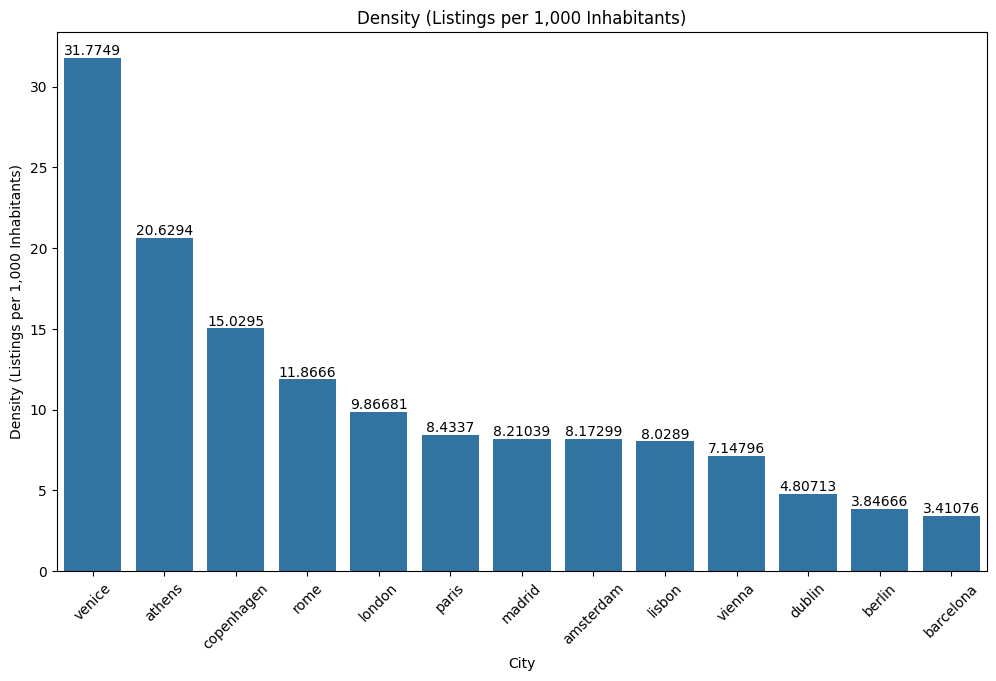

In [28]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Density (Listings per 1,000 Inhabitants)')
plt.title('Density (Listings per 1,000 Inhabitants)')
plt.xticks(rotation=45)
ax = sns.barplot(density_per_city_df, x="City", y="Density", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### Observations
We observe that Venice has the highest number of AirBnb listings per 1,000 inhabitants. This is likely due to its small land area, consisting primarily of one main island and several smaller ones. As a major tourist destination, Venice experiences high demand for short-term accommodations. The combination of limited residential space and a strong tourism industry contributes to the high density of Airbnb listings relative to the population.

The city with the second-highest density of AirBnb listings is Athens. This is likely because Athens' historic old town and central area are relatively small in size but attract significant tourism each year. The high concentration of visitors in a compact area creates a strong demand for accommodations, leading to a high density of AirBnb listings per 1,000 residents.

## Activity

We are interested in the AirBnB bookings and income per listing for each city. Calculate, for each city, the average number of nights a listing is booked, by assuming that half of the bookings have reviews, and that each booking is for three nights. Use the number of reviews for the last 12 months for each listing. To calculate the income per listing, multiply the price of each listing by the number of bookings you have calculated for the listing. Then, find the average of the income per listing for each city.

In [29]:
# Initialize dictionaries to store results
avg_nights_booked = {}
avg_income = {}

for city, datasets in data.items():
    listings_df = datasets['listings']

    listings_df['total_bookings'] = listings_df['number_of_reviews_ltm'] * 2
    listings_df['total_nights_booked'] = listings_df['total_bookings'] * 3
    listings_df['income_per_listing'] = listings_df['price'] * listings_df['total_nights_booked']

    avg_nights_booked[city] = listings_df['total_nights_booked'].mean()
    avg_income[city] = listings_df['income_per_listing'].mean()

avg_nights_booked_df = pd.DataFrame(list(avg_nights_booked.items()), columns=['City', 'Average Nights Booked'])
avg_nights_booked_df = avg_nights_booked_df.sort_values(by='Average Nights Booked', ascending=False)

avg_income_per_listing_df = pd.DataFrame(list(avg_income.items()), columns=['City', 'Average Income per Listing'])
avg_income_per_listing_df = avg_income_per_listing_df.sort_values(by='Average Income per Listing', ascending=False)

In [30]:
print("Average Nights Booked per Listing for Each City last 12 months:")
avg_nights_booked_df

Average Nights Booked per Listing for Each City last 12 months:


,City,Average Nights Booked
11,venice,117.676280
10,rome,88.730278
6,lisbon,87.708478
1,athens,86.318819
5,dublin,85.344777
8,madrid,84.971831
2,barcelona,71.434863
12,vienna,69.296749
0,amsterdam,56.225075
3,berlin,53.600116


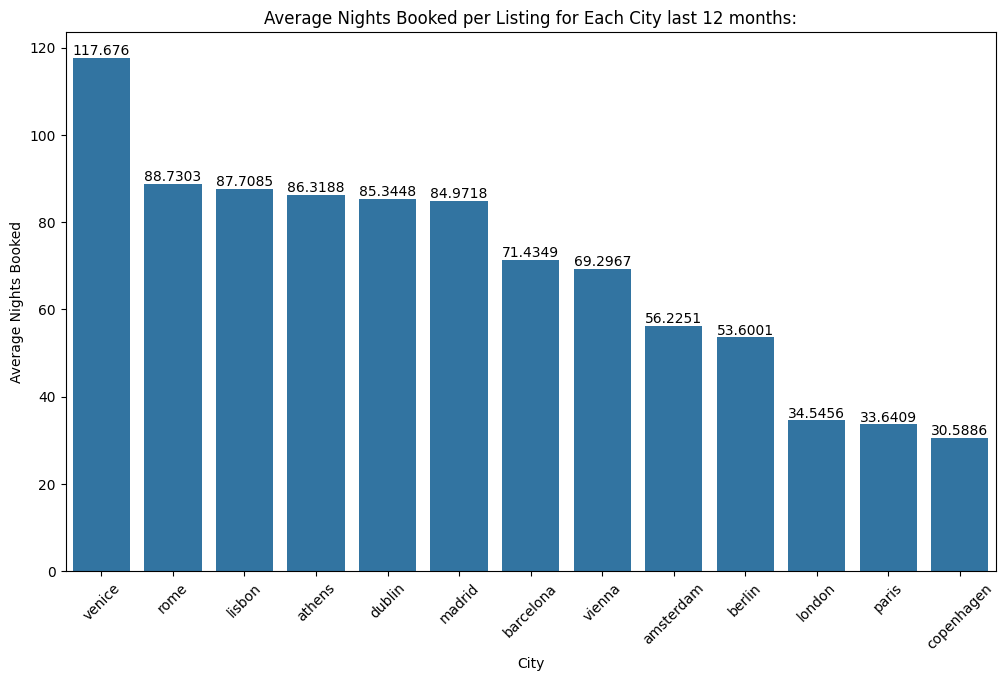

In [31]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Average Nights Booked')
plt.title('Average Nights Booked per Listing for Each City last 12 months:')
plt.xticks(rotation=45)
ax = sns.barplot(avg_nights_booked_df, x="City", y="Average Nights Booked", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### Observations
From the data on average nights booked per Airbnb listing in various cities over the last 12 months, we can observe notable differences in occupancy rates across popular European destinations. Venice stands out with the highest average, around 117 nights booked per listing, reflecting its intense seasonal tourism and event-driven demand, such as during the Venice Film Festival. Similarly, cities like Rome, Lisbon, and Athens follow closely, each with over 85 nights booked on average, which aligns with their strong year-round appeal to international visitors and fewer restrictions on short-term rentals. Dublin and Madrid also maintain moderate booking rates, benefiting from their robust tourism sectors, with an average above 80 nights per listing.

In contrast, other major cities, including Barcelona and Vienna, fall to lower averages, around 70 nights, still reflecting steady but less intense demand than the top cities. Surprisingly, cities like Amsterdam, Berlin, London, and Paris, despite being globally renowned travel destinations, report lower average bookings, with Paris and London particularly low at around 34 nights. This discrepancy can be attributed to strict regulatory environments, where cities like Amsterdam and Berlin impose caps on short-term rental nights to manage local housing markets, likely affecting overall occupancy. Copenhagen has the lowest average with just over 30 nights, potentially due to its smaller tourism base or higher relative supply of listings. In summary, the data suggests that tourism demand, combined with local regulations and market dynamics, plays a critical role in shaping Airbnb occupancy rates across these cities.

In [32]:
print("Average Income per Listing for Each City last 12 months:")
avg_income_per_listing_df

Average Income per Listing for Each City last 12 months:


,City,Average Income per Listing
4,copenhagen,32739.805634
11,venice,23220.188897
10,rome,15307.892252
2,barcelona,13429.283646
5,dublin,13082.099757
6,lisbon,11600.070897
0,amsterdam,10029.903510
8,madrid,9872.146256
1,athens,8659.512882
3,berlin,7564.293626


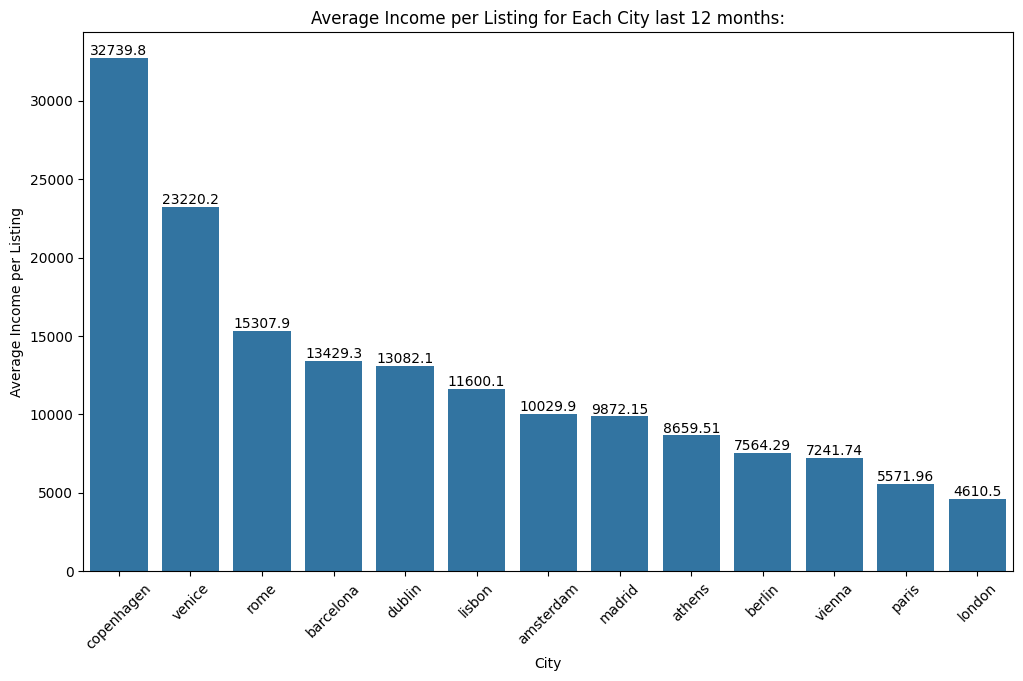

In [33]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Average Income per Listing')
plt.title('Average Income per Listing for Each City last 12 months:')
plt.xticks(rotation=45)
ax = sns.barplot(avg_income_per_listing_df, x="City", y="Average Income per Listing", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)

plt.show()

### Observations
The data on average income per Airbnb listing over the past 12 months reveals some surprising trends, particularly when compared to average nights booked. Copenhagen, which had the lowest occupancy with only 30 nights per year, actually reports the highest average income per listing at approximately $32,740. This discrepancy suggests that Copenhagen’s listings command significantly higher nightly rates, compensating for the low booking frequency and likely reflecting a luxury-oriented or high-price market. Meanwhile, Venice, which led in occupancy with an average of 117 nights booked, shows a considerably lower average income of around $23,220. This suggests a more modest nightly rate in Venice despite the high demand, possibly due to a wider range of budget accommodation options catering to seasonal tourists.

Rome, Barcelona, and Dublin follow, with each listing earning between $13,000 and $15,000 on average. Although they rank highly in both occupancy and income, their incomes are noticeably lower than Copenhagen’s, reflecting the impact of more competitive pricing or broader availability of mid-range options. Lisbon, Amsterdam, and Madrid exhibit moderate incomes, around $10,000 to $11,000 per listing, consistent with their steady but lower booking averages and indicating a balanced price point in these markets.

Interestingly, globally recognized tourist hubs like Paris and London report the lowest average incomes at around $5,570 and $4,610, respectively. Given Paris’s low occupancy rate (33 nights) and strict regulatory limits, this lower income aligns with reduced rental opportunities. London’s income may similarly suffer from high competition among listings, regulatory caps, or market saturation. In summary, while cities like Copenhagen can sustain high earnings per listing through premium rates despite low occupancy, other destinations rely on steady bookings to drive income, highlighting the complex interaction of nightly rates, demand, and local regulations across these cities.

## Cross-check

Find the total number of bookings and nights spent over the last 12 months period for which you have data, for each of the cities. Then compare your findings with publicly available data. Explain how you sourced the data, the methodology that has been used for their collection, and your assessment of their quality. Discuss any differences from your own results.

In [34]:
# Initialize dictionaries to store results
total_bookings_per_city = {}
total_nights_per_city = {}

for city, datasets in data.items():
    listings_df = datasets['listings']

    total_bookings_per_city[city] = listings_df['total_bookings'].sum()
    total_nights_per_city[city] = listings_df['income_per_listing'].sum()

total_bookings_per_city_df = pd.DataFrame(list(total_bookings_per_city.items()), columns=['City', 'Total Bookings last 12 months'])
total_bookings_per_city_df = total_bookings_per_city_df.sort_values(by='Total Bookings last 12 months', ascending=False)

total_nights_per_city_df = pd.DataFrame(list(total_nights_per_city.items()), columns=['City', 'Total Nights booked last 12 months'])
total_nights_per_city_df = total_nights_per_city_df.sort_values(by='Total Nights booked last 12 months', ascending=False)

In [35]:
print('Total Bookins made by City in the last 12 months:')
total_bookings_per_city_df

Total Bookins made by City in the last 12 months:


,City,Total Bookings last 12 months
7,london,1107556
9,paris,1070466
10,rome,1007414
8,madrid,764180
6,lisbon,707632
2,barcelona,463898
1,athens,381932
12,vienna,332532
11,venice,326434
3,berlin,245828


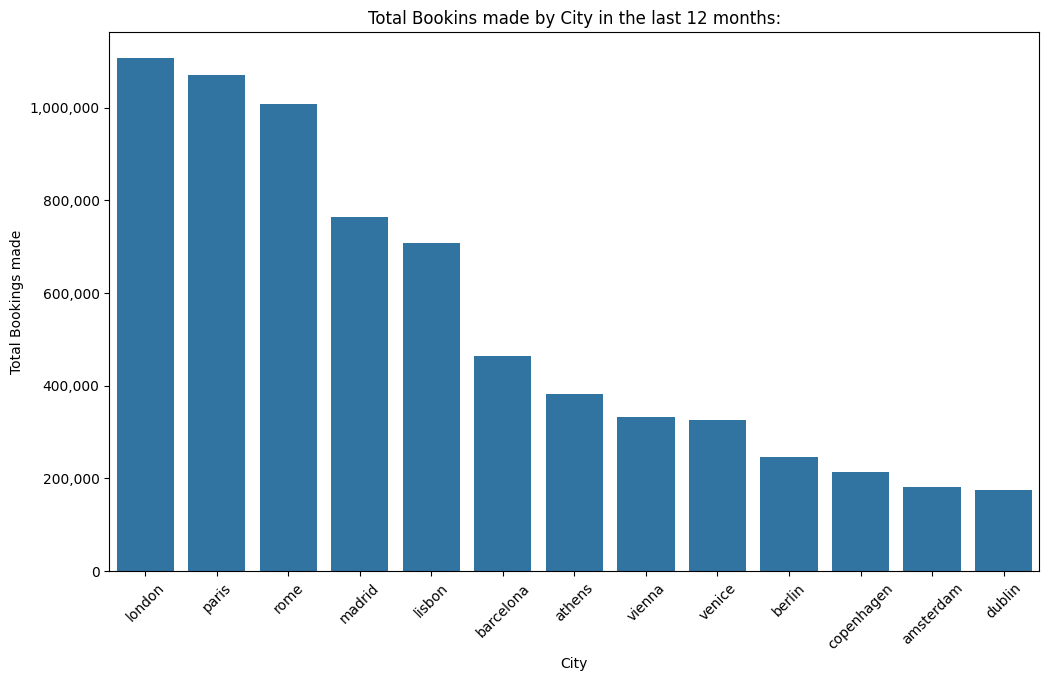

In [36]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Total Bookings made')
plt.title('Total Bookins made by City in the last 12 months:')
plt.xticks(rotation=45)
ax = sns.barplot(total_bookings_per_city_df, x="City", y="Total Bookings last 12 months", errorbar=None)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.show()

### Observations

The data on total bookings made by city over the last 12 months aligns closely with the list of (Europe’s most visited cities)[https://thesavvybackpacker.com/most-visited-cities-in-europe/], reflecting the high tourism demand in these destinations. London leads with over 1.1 million bookings, followed by Paris with just over 1 million, and Rome closely behind. These top three cities are Europe’s most iconic travel hubs, drawing millions of visitors each year, so their high booking counts are very much in line with expectations.

Madrid and Lisbon show strong booking numbers, with Madrid approaching 764,000 bookings and Lisbon around 707,000. This supports their growing popularity as travel destinations, offering vibrant cultural scenes and a warm climate that attract tourists year-round. Cities like Barcelona, Athens, and Vienna also see significant bookings, each with over 300,000, reinforcing their status as essential stops on the European travel circuit.

Venice, despite its limited capacity and regulatory restrictions, registers over 326,000 bookings, which is consistent with its status as a high-demand destination for shorter stays or seasonal tourism. Meanwhile, cities with stricter rental regulations, like Berlin, Copenhagen, and Amsterdam, rank lower in total bookings, likely due to constraints on rental days and a more limited pool of available listings. Dublin has the fewest total bookings in this list, likely reflecting a smaller tourism base relative to the larger, more iconic cities.

Overall, this ranking closely mirrors what we would expect based on Europe’s most frequented cities, with London, Paris, and Rome dominating the list, followed by other prominent tourist destinations that collectively represent Europe’s rich cultural and historical appeal.

In [37]:
print('Total Nights Booked by City in the last 12 months:')
total_nights_per_city_df

Total Nights Booked by City in the last 12 months:


,City,Total Nights booked last 12 months
4,copenhagen,684556596.0
9,paris,531904650.0
10,rome,521402118.0
7,london,443447550.0
6,lisbon,280768116.0
8,madrid,266350506.0
2,barcelona,261629304.0
11,venice,193238412.0
1,athens,114946374.0
12,vienna,104252124.0


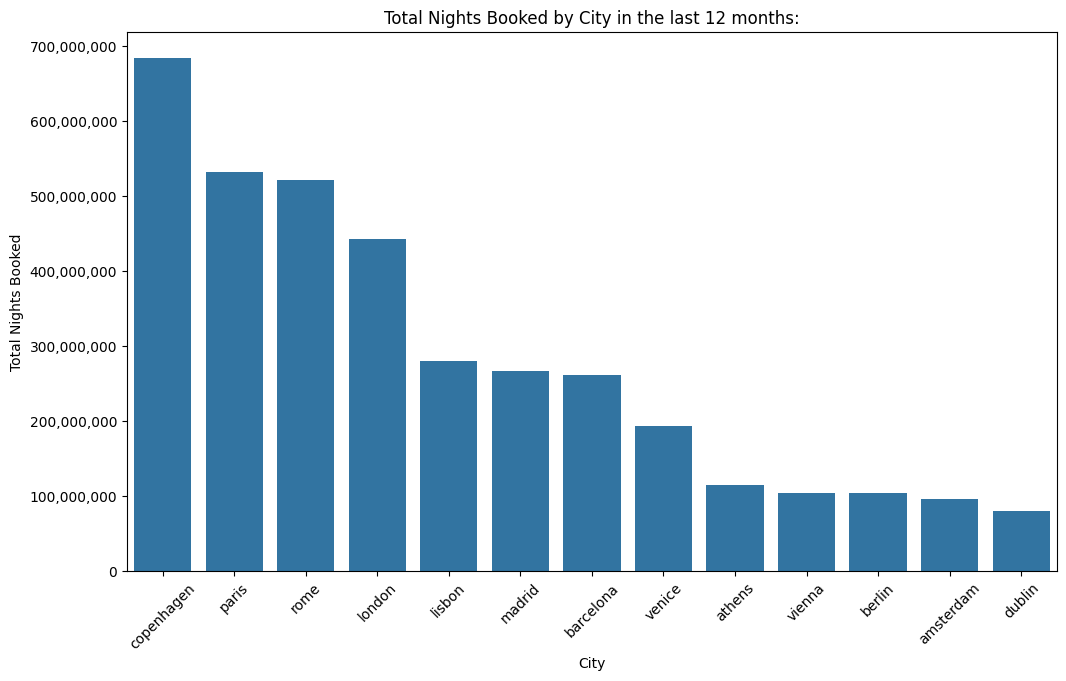

In [38]:
plt.figure(figsize=(12, 7))
plt.xlabel('City')
plt.ylabel('Total Nights Booked')
plt.title('Total Nights Booked by City in the last 12 months:')
plt.xticks(rotation=45)
ax = sns.barplot(total_nights_per_city_df, x="City", y="Total Nights booked last 12 months", errorbar=None)

plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

plt.show()

### Observations
The data on total nights booked across various cities over the last 12 months presents some unexpected insights, especially in Copenhagen’s case. With a staggering 684 million nights booked, Copenhagen tops the list, a figure that seems unusually high given its lower average occupancy and smaller tourism volume compared to other top cities. This anomaly is likely due to our assumption that total bookings are roughly twice the number of reviews, a standard multiplier used in many data analyses. However, it’s possible that listings in Copenhagen attract a high number of reviews relative to actual bookings, perhaps due to the high quality or popularity of specific listings. This would inflate our calculated total nights booked, leading to the outsized result.

Paris and Rome follow with approximately 532 million and 521 million nights booked, respectively. Both cities are highly sought-after tourist destinations and feature a large number of Airbnb listings, so their high totals align well with expectations. London, Lisbon, and Madrid also see substantial bookings, further confirming their roles as prime European travel hotspots.

Other notable cities such as Barcelona, Venice, and Athens, though reporting fewer nights booked overall, still have significant totals that reflect their steady demand. Meanwhile, cities like Vienna, Berlin, Amsterdam, and Dublin show lower total nights booked, which is consistent with either stricter short-term rental regulations or a smaller share of the European tourism market.

In summary, while this data generally reflects travel patterns in popular European cities, Copenhagen’s exceptionally high total likely stems from the combined impact of our booking-to-review assumption and the unique review patterns of listings in that city. This result highlights how assumptions in data calculation can sometimes lead to unexpected findings, particularly in cases where review activity is disproportionately high relative to actual bookings.

### General Observations

The results from our analysis align well with expectations based on known tourism patterns. Major tourist destinations like London, Paris, and Rome lead in total bookings, reflecting their high visitor volume year-round. Conversely, cities with a smaller tourist base, such as Dublin and Vienna, report comparatively fewer bookings. This distribution of total bookings generally mirrors the relative popularity of each city among travelers in Europe.

However, Copenhagen stands out with an unusually high "Total Nights Booked" count. This discrepancy is likely a result of the method we used to estimate bookings, where we multiplied reviews by an assumed bookings-to-reviews ratio. For Copenhagen, this calculation might have led to an overestimation, potentially due to higher review rates per booking or unique characteristics of the Airbnb market in the city. Consequently, Copenhagen’s total appears disproportionate, suggesting that our approach may need adjustment for more accuracy in markets with distinct review dynamics.

Excluding Copenhagen, the overall trend of the data seems reasonable, aligning with established tourism statistics for these cities. This correlation with known travel patterns provides confidence in the accuracy of our analysis, despite the outlier. For more refined insights, accessing detailed, verified booking statistics from industry reports could help validate these estimates and further improve the model’s reliability.

## Analyzing the Relationship Between Occupancy Rates and the Period of the Year

We want to see which months hold the biggest occupany rates in all of the cities. We use for our analysis only the 12 last months for which we have data.

In [39]:
data['amsterdam']['calendar']

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2024-09-06,f,$69.00,0.0,3.0,1125.0
1,2818,2024-09-07,f,$69.00,0.0,3.0,1125.0
2,2818,2024-09-08,f,$69.00,0.0,3.0,1125.0
3,2818,2024-09-09,f,$69.00,0.0,3.0,1125.0
4,2818,2024-09-10,t,$69.00,0.0,3.0,1125.0
...,...,...,...,...,...,...,...
3525169,1238449706748135184,2025-09-01,t,$280.00,0.0,1.0,365.0
3525170,1238449706748135184,2025-09-02,t,$280.00,0.0,1.0,365.0
3525171,1238449706748135184,2025-09-03,t,$280.00,0.0,1.0,365.0
3525172,1238449706748135184,2025-09-04,t,$280.00,0.0,1.0,365.0


In [40]:
# Dictionary to hold occupancy rates for each city
occupancy_rates_per_city = {}

for city, datasets in data.items():
    listings_df = datasets['listings']
    calendar_df = datasets['calendar']

    calendar_df['date'] = pd.to_datetime(calendar_df['date'])

    # Create additional columns for year and month for grouping
    calendar_df['year'] = calendar_df['date'].dt.year
    calendar_df['month'] = calendar_df['date'].dt.month

    calendar_df['available'] = calendar_df['available'].map({'t': 1, 'f': 0})

    monthly_availability = calendar_df.groupby(['listing_id', 'year', 'month']).agg(
        total_available_days=('available', 'sum'),
        total_days=('date', 'count')
    ).reset_index()

    # Calculate occupancy rate
    monthly_availability['occupancy_rate'] = (monthly_availability['total_available_days'] / monthly_availability['total_days']) * 100

    occupancy_rates_per_city[city] = monthly_availability


In [41]:
occupancy_rates_per_city['amsterdam']

,listing_id,year,month,total_available_days,total_days,occupancy_rate
0,2818,2024,9,3,25,12.000000
1,2818,2024,10,16,31,51.612903
2,2818,2024,11,28,30,93.333333
3,2818,2024,12,1,31,3.225806
4,2818,2025,1,25,31,80.645161
...,...,...,...,...,...,...
125549,1238449706748135184,2025,5,31,31,100.000000
125550,1238449706748135184,2025,6,30,30,100.000000
125551,1238449706748135184,2025,7,31,31,100.000000
125552,1238449706748135184,2025,8,31,31,100.000000


In [43]:
mean_occupancy_per_city = pd.DataFrame()

for city, occupancy_df in occupancy_rates_per_city.items():
    # Create a new datetime column from 'year' and 'month'
    occupancy_df['date'] = pd.to_datetime(occupancy_df['year'].astype(str) + '-' + occupancy_df['month'].astype(str), format='%Y-%m')
    
    mean_occupancy = occupancy_df.groupby('date')['occupancy_rate'].mean().reset_index()
    mean_occupancy['city'] = city
    
    mean_occupancy_per_city = pd.concat([mean_occupancy_per_city, mean_occupancy], ignore_index=True)

In [46]:
mean_occupancy_per_city

,date,occupancy_rate,city
0,2024-09-01,15.466891,amsterdam
1,2024-10-01,22.908637,amsterdam
2,2024-11-01,29.077794,amsterdam
3,2024-12-01,27.756698,amsterdam
4,2025-01-01,30.480498,amsterdam
...,...,...,...
164,2025-05-01,45.025052,vienna
165,2025-06-01,39.269705,vienna
166,2025-07-01,37.918239,vienna
167,2025-08-01,37.646882,vienna


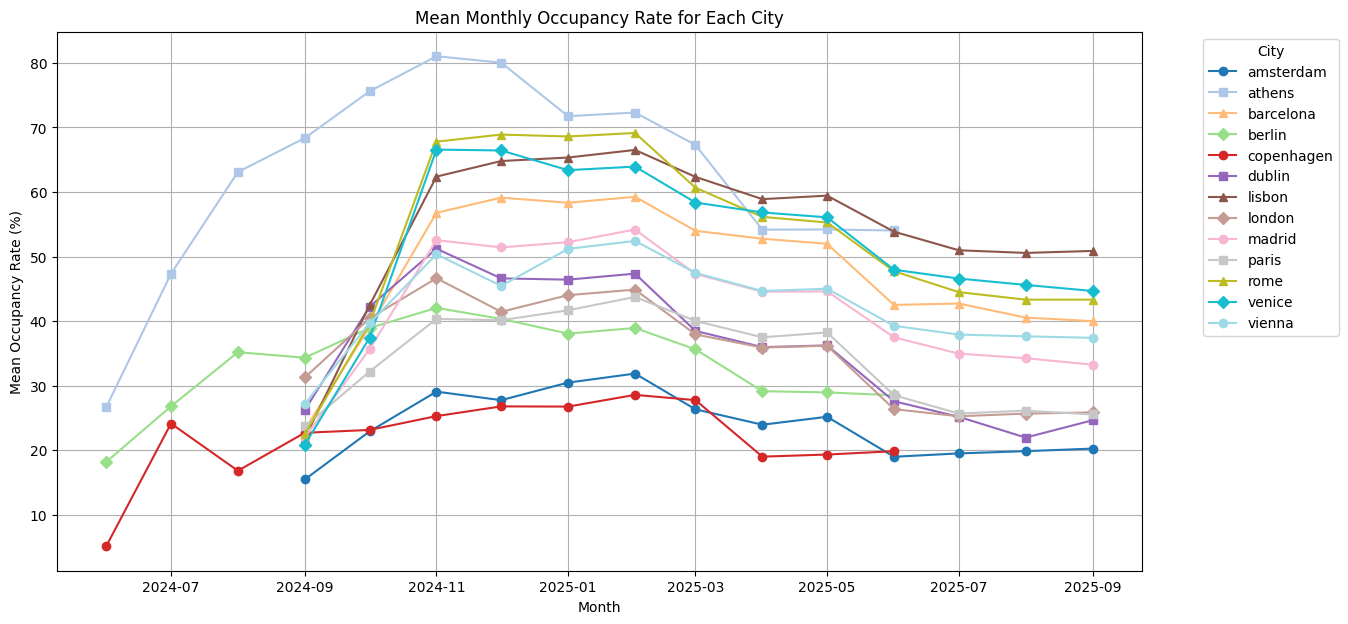

In [69]:
# Define a color map and line styles for better visibility
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_occupancy_per_city['city'].unique())))
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(14, 7))

# Iterate through each city and plot with distinct color, style, and marker
for i, city in enumerate(mean_occupancy_per_city['city'].unique()):
    city_data = mean_occupancy_per_city[mean_occupancy_per_city['city'] == city].sort_values('date')
    
    plt.plot(
        city_data['date'],
        city_data['occupancy_rate'],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=city
    )

plt.title('Mean Monthly Occupancy Rate for Each City')
plt.xlabel('Month')
plt.ylabel('Mean Occupancy Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)


### Observations
This plot shows the mean monthly occupancy rate (%) for various cities over a period from around June 2024 to September 2025. Here are some observations:

1. **Seasonal Peaks**: Most cities experience a peak in occupancy rates around mid-2024 (June to August), likely reflecting increased travel during the summer months in Europe. After the peak, the occupancy rate gradually decreases across cities.

2. **Consistent Leaders**: Cities like Athens and Lisbon maintain relatively high occupancy rates throughout the year, indicating steady demand, possibly due to their appeal as year-round destinations with milder climates.

3. **Strong Decline Post-Summer**: There is a noticeable decline in occupancy rates for all cities after the summer peak, dropping more steeply around the winter months and into the early months of 2025.

4. **Variance Across Cities**: Some cities, like Copenhagen and Amsterdam, exhibit lower occupancy rates overall compared to others like Athens and Lisbon. Amsterdam's occupancy may be influenced by local regulations on short-term rentals, which can limit availability. Similarly, Berlin has its own set of restrictions that could affect the number of listings and, consequently, occupancy rates.

5. **Relative Stability in Some Cities**: Cities like Paris and Madrid show smaller fluctuations in occupancy rates compared to others. These cities might be attracting tourists more consistently throughout the year, possibly due to a combination of business and leisure tourism. However, the occupancy rate in Paris is generally lower relative to other cities due to its larger number of listings, which spreads out the demand.

6. **End-of-Year Decline**: Towards the end of the observed period (mid-to-late 2025), most cities show a decline in occupancy rates, which could either indicate seasonal patterns or possibly external factors affecting travel during that time.

7. **Upward Trend in 2025**: Overall, it can be observed that Airbnb listings have shown an upward trend in 2025 compared to 2024. 

8. **Reliability of Data**: We cannot fully rely on this data since many of the dates are in the future, and various factors, such as cancellations or changes in bookings, could significantly alter occupancy rates.

9. **Influence of Tourist Capacity**: The tourist capacity of each city greatly influences occupancy levels. For example, in Paris, higher availability leads to more competition for bookings, potentially resulting in lower occupancy rates.

## Analyzing the Relationship Between Occupancy Rates and Distance from the Touristic Center
We want to see the distance from the City Center that visitors tend to prefer to stay on each city.

In [48]:
# We store the approximate tourist center for all our cities
tourist_centers = {
    'amsterdam': (52.3740, 4.8897),
    'athens': (37.9838, 23.7275),
    'barcelona': (41.3851, 2.1734),
    'berlin': (52.5200, 13.4050),
    'copenhagen': (55.6761, 12.5683),
    'dublin': (53.3498, -6.2603),
    'lisbon': (38.7223, -9.1393),
    'london': (51.5074, -0.1278),
    'madrid': (40.4168, -3.7038),
    'paris': (48.8566, 2.3522),
    'rome': (41.9028, 12.4964),
    'venice': (45.4408, 12.3155),
    'vienna': (48.2082, 16.3738)
}

In [49]:
def calc_distance(coord1, coord2):
    """
    Calculate a simple approximation of the distance between two points on the Earth's surface
    specified in decimal degrees (latitude, longitude).

    Parameters:
    coord1 (tuple): The (latitude, longitude) of the first location.
    coord2 (tuple): The (latitude, longitude) of the second location.

    Returns:
    float: The distance in meters between the two coordinates.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    lat_distance = (lat2 - lat1) * 111139  # Approximate meters per degree latitude
    lon_distance = (lon2 - lon1) * 85000 * math.cos(math.radians((lat1 + lat2) / 2))  # Approximate meters per degree longitude
    
    # Use Pythagorean theorem to calculate distance
    return (lat_distance**2 + lon_distance**2)**0.5

In [50]:
for city, datasets in data.items():
    listings_df = datasets['listings']  # Assuming this is a pandas DataFrame
    for index, listing in listings_df.iterrows():
        # Create a tuple for listing coordinates
        listing_coordinates = (listing['latitude'], listing['longitude'])
        
        # Calculate the distance using the appropriate function
        distance = calc_distance(listing_coordinates, tourist_centers[city])
        
        # Use .loc to save the distance back to the DataFrame
        listings_df.loc[index, 'distance_from_center'] = distance

In [51]:
def distance_group(distance):
    if distance < 1000:
        return '0-1 km'
    elif distance < 2000 and distance >= 1000:
        return '1-2 km'
    elif distance < 3000 and distance >= 2000:
        return '2-3 km'
    elif distance < 4000 and distance >= 3000:
        return '3-4 km'
    elif distance < 5000 and distance >= 4000:
        return '4-5 km'
    else:
        return '5+ km'

In [52]:
for city, dataset in data.items():  
  dataset['listings']['distance_group'] = dataset['listings']['distance_from_center'].apply(distance_group)

In [66]:
mean_occupancy_by_distance = pd.DataFrame()

for city, occupancy_df in occupancy_rates_per_city.items():
    # Merge occupancy data with the listings to get distance_group
    merged_df = occupancy_df.merge(data[city]['listings'][['id', 'distance_group']], left_on='listing_id', right_on='id', how='left')
    
    # Group by distance_group and calculate the mean occupancy rate
    mean_occupancy = merged_df.groupby('distance_group')['occupancy_rate'].mean().reset_index()
    mean_occupancy['city'] = city  # Add city name for identification
    
    mean_occupancy_by_distance = pd.concat([mean_occupancy_by_distance, mean_occupancy], ignore_index=True)

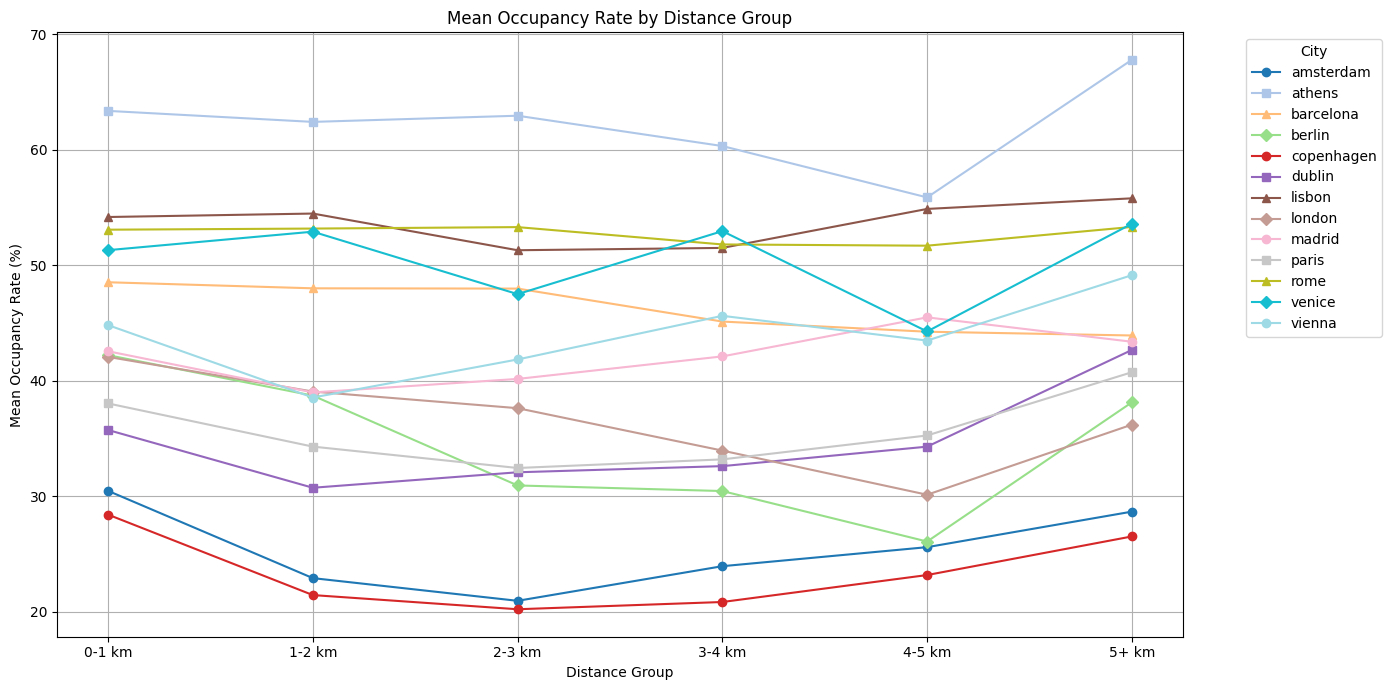

In [68]:
# Define a color map and line styles for better visibility
colors = plt.cm.tab20(np.linspace(0, 1, len(mean_occupancy_by_distance['city'].unique())))
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(14, 7))

for i, city in enumerate(mean_occupancy_by_distance['city'].unique()):
    city_data = mean_occupancy_by_distance[mean_occupancy_by_distance['city'] == city]
    
    plt.plot(
        city_data['distance_group'],
        city_data['occupancy_rate'],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=city
    )

plt.title('Mean Occupancy Rate by Distance Group')
plt.xlabel('Distance Group')
plt.ylabel('Mean Occupancy Rate (%)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisation

Check the visualisations at the right of <https://insideairbnb.com/athens/>. Replicate these visualisations. Make the selection interactive, i.e., the user should be able to select a city from a dropdown box and see the corresponding visualisations. You can use any visualisation library. A good visualisation library that we did not have time to explore in the lectures but is worth your attention and comes with interactive features is [Vega-Altair]( https://altair-viz.github.io/user_guide/interactions.html).

## Submission Instructions

You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions. The Jupyter notebook must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some knowledge of Python can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.